<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/Full_Version_OCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 8.1 MB/s eta 0:00:00


In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def solve_ocp(k_value):
    # Time and discretization
    tf = 40        # final time [sec]
    N = 80         # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(N+1)
    h_s = opti.variable(N+1)
    V_s = opti.variable(N+1)
    gamma_s = opti.variable(N+1)
    alpha_s = opti.variable(N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2
        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Integration using RK4
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    # rhs = aircraft_ode(X_sym, u_sym)
    # Not support for t
    # intg = ca.integrator("intg", "rk", {
    #     "x": X_sym, "p": u_sym, "ode": rhs
    # }, {
    #     "tf": dt,
    #     "number_of_finite_elements": 4  # RK4
    # })
    def rk4_step(f, xk, uk, tk, dt):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # Initial conditions
    opti.subject_to(x_s[0] == 0)
    opti.subject_to(h_s[0] == 600 / hscale)
    opti.subject_to(V_s[0] == 239.7 / Vscale)
    opti.subject_to(V_s[:] >= 1e-2 / Vscale)
    opti.subject_to(gamma_s[0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[0] == min(0.1283, alphascale) / alphascale)
    opti.subject_to(gamma_s[-1] == -0.05236 / gammascale)

    for i in range(N):
        tk = i * dt     # New line
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        # Xk_end = intg(x0=Xk, p=Uk)["xf"]
        Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt)
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(opti.bounded(-1, u_s[i], 1))
        opti.subject_to(opti.bounded(-1, alpha_s[i], 1))

    # Cost function
    J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x_s, ca.linspace(0, 1, N+1))
    opti.set_initial(h_s, 0.6)
    opti.set_initial(V_s, 239.7 / Vscale)
    opti.set_initial(gamma_s, -0.01 / gammascale)
    opti.set_initial(alpha_s, 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })

    try:
        # opti.callback(lambda i: print("Alpha max:", np.max(opti.debug.value(alpha_s))))
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [4]:
res = solve_ocp(1.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2486
Number of nonzeros in inequality constraint Jacobian.:      241
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      485
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      406
Total number of inequality c

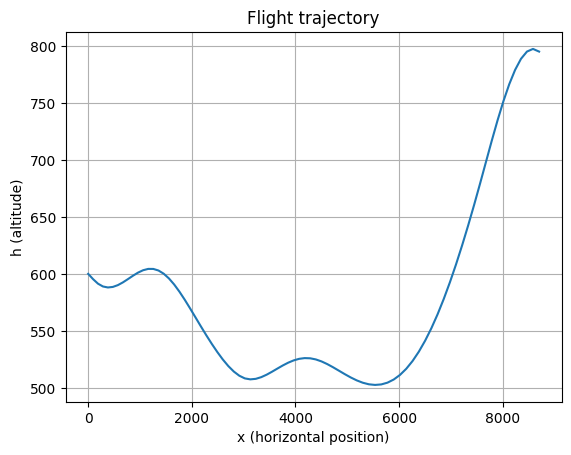

In [5]:
plt.figure()
plt.plot(res["x"], res["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.grid()
plt.show()

In [6]:
def reconstruct_trajectory(u_opt, k_value):
    # 参数
    tf = 40
    N = 80
    dt = tf / N
    m = 4662
    g = 32.172
    delta = 0.03491
    A0, A1, A2 = 0.4456e5, -0.2398e2, 0.1442e-1
    rho, S = 0.2203e-2, 0.1560e4
    B0, B1, B2 = 0.1552, 0.12369, 2.4203
    C0, C1, C2 = 0.7125, 6.0877, -9.0277
    alpha_star = 0.20944
    h_star = 1000

    # Wind model parameters
    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11
    eps = 1e-6

    # 初始状态
    x0 = 0.0
    h0 = 600.0
    V0 = 239.7
    gamma0 = -0.03925
    alpha0 = min(0.1283, 0.3)
    Xk = ca.DM([x0, h0, V0, gamma0, alpha0])

    # 储存轨迹
    x_traj = [x0]
    h_traj = [h0]

    # 辅助函数
    def Smooth(x_, x0_, x1_):
        t = (x_ - x0_) / (x1_ - x0_ + eps)
        return ca.if_else(x_ < x0_, 0,
               ca.if_else(x_ > x1_, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_): return k_value * A_piecewise(x_)
    def wind_h(x_, h_): return k_value * ca.fmax(h_, 10.0) / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star,
                          C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)

    def beta(t_):
        beta0, beta_dot0, sigma = 0.4, 0.2, 3
        return beta0 + beta_dot0 * t_ if t_ < sigma else 1.0

    def aircraft_ode(X, u_, t_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2
        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        # 近似导数
        h_eps = 1e-3
        x_eps = 1e-3
        dWx_dx = (wind_x(x_ + x_eps) - wind_x(x_ - x_eps)) / (2 * x_eps)
        dWh_dx = (wind_h(x_ + x_eps, h_) - wind_h(x_ - x_eps, h_)) / (2 * x_eps)
        dWh_dh = (wind_h(x_, h_ + h_eps) - wind_h(x_, h_ - h_eps)) / (2 * h_eps)

        Wx_dot = dWx_dx * x_dot
        Wh_dot = dWh_dx * x_dot + dWh_dh * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_
        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # 模拟
    for i in range(N):
        tk = i * dt
        uk = u_opt[i]
        Xk = rk4_step(aircraft_ode, Xk, uk, tk, dt)
        x_traj.append(float(Xk[0]))
        h_traj.append(float(Xk[1]))

    return np.array(x_traj), np.array(h_traj)

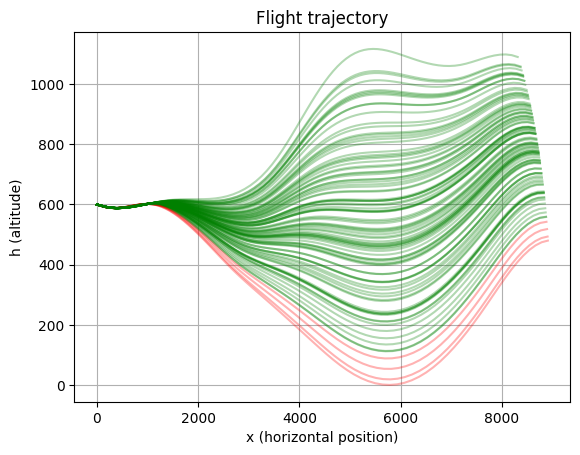

In [7]:
u_opt = res["u"]

for k in np.random.normal(1, 0.25, 100):
    x_traj, h_traj = reconstruct_trajectory(u_opt, k)
    if min(h_traj) < 100:
        plt.plot(x_traj, h_traj, color='red', alpha = 0.3, label=f"k={k:.2f}")
    else:
        plt.plot(x_traj, h_traj, color='green', alpha = 0.3, label=f"k={k:.2f}")

plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.grid()
# plt.legend()
plt.show()

## Monte Carlo

In [8]:
np.random.seed(0)

failure = 0

for k in np.random.normal(1, 0.08, 1000):
    x_traj, h_traj = reconstruct_trajectory(u_opt, k)

    if min(h_traj) <= 0:
        failure += 1

print(f'The failure probability is {failure/10:.2f}\%.')

The failure probability is 0.00\%.


## Subset Simulation

In [21]:
def sample_new_G(k, G, N, c_l, gamma=0.5):
    """
    Generate correlated samples using MCMC with fixed precision noise.

    Implements Modified Metropolis algorithm with AR(1) proposal distribution
    and fixed precision parameterization.

    Args:
        k (array): Current noisy evaluations (k <= c_l)
        G (array): True limit state samples
        N (int): Target sample count
        c_l (float): Current threshold value
        gamma (float): Base noise scaling factor

    Returns:
        tuple: Updated (k, G) arrays with new samples
    """
    N0 = len(k)
    rho = 0.8  # AR(1) correlation coefficient

    for i in range(N - N0):
        # Generate correlated proposal
        k_new = rho * k[i] + np.sqrt(1 - rho**2) * np.random.normal(1, 0.08)

        _, h_traj = reconstruct_trajectory(u_opt, k_new)
        G_new = np.min(h_traj)

        # Acceptance/rejection with sample recycling
        if k_new <= c_l:
            k = np.append(k, k_new)
            G = np.append(G, G_new)
        else:
            # Maintain chain length with previous sample
            k = np.append(k, k[i])
            G = np.append(G, G[i])

    return k, G

In [22]:
def subset_simulation(N, y_L=0, p0=0.1, gamma=0.8, L=9):
    """
    Subset Simulation core algorithm for rare event probability estimation.

    Args:
        N (int): Samples per simulation level
        y_L (float): Final failure threshold
        p0 (float): Conditional probability target per level
        gamma (float): Noise scaling factor
        L (int): Maximum number of subsets

    Returns:
        tuple: (failure probability estimate, total computational cost)
    """
    N0 = int(N * p0)  # Surviving samples per level
    cost = 0

    # Level 1: Initial sampling
    k = np.random.normal(1, 0.08, N0)
    G = []

    for k_ in k:
        _, h_traj = reconstruct_trajectory(u_opt, k_)
        G.append(np.min(h_traj))

    # Determine first threshold
    G = np.array(G)
    c_l = np.percentile(G, 100 * p0)
    mask = G <= c_l
    G, k = G[mask][:N0], k[mask][:N0]

    # Multi-level processing
    for l in range(2, L):
        # MCMC sampling phase
        k, G = sample_new_G(k, G, N, c_l, gamma)

        # Update threshold
        c_l = np.percentile(G, 100 * p0)

        # Early termination check
        if c_l <= y_L:
            mask = G <= y_L
            return p0 ** (l-1) * np.mean(mask)

        # Shuffle to break correlation before resampling
        indices = np.random.permutation(len(G))
        G, k = G[indices], k[indices]

        # Resample for next level
        mask = G <= c_l
        G, k = G[mask][:N0], k[mask][:N0]

    # Final level processing
    G, k = sample_new_G(k, G, N, c_l, gamma)
    mask = k <= y_L

    return p0 ** (L-1) * np.mean(mask)

In [23]:
np.random.seed(108)

P_f = subset_simulation(1000)

In [24]:
print(f'The failure probability is {P_f:.2f}.')

The failure probability is 0.10.
